In [155]:
include("../src/HPFEM.jl")

HPFEM

In [182]:
TF = Float64
nel = 10
nnodes = nel + 1
idir = [1,nnodes]
M = 7
Q = M+2
b = HPFEM.Lagrange1d(M, TF)
quad = HPFEM.QuadType(Q, HPFEM.GLJ, TF)
bas = HPFEM.Basis1d(b,quad, TF)
#bas = HPFEM.SEM1d(M)
#bas = HPFEM.Basis1d(M,Q)
lmap = HPFEM.locmap(bas)
dof = HPFEM.DofMap1d(lmap, nnodes, idir);


In [183]:
typeof(bas)

HPFEM.Basis1d{Float64,HPFEM.Lagrange1d{Float64}}

In [184]:
k = 2
uexact(x) = sin(2π*k*x)
rhsfun(x) = sin(2π*k*x) * (1.0 + (2π*k)^2)


rhsfun (generic function with 1 method)

In [185]:
a = 1.7
b = 10.3
nodes = [TF(x) for x in linspace(a, b, nnodes)];

In [186]:
elems = [HPFEM.Element1d(e, nodes[e], nodes[e+1], bas) for e = 1:nel];

In [187]:
solver = HPFEM.CholeskySC(dof, HPFEM.BBSymTri, TF);

In [188]:
typeof(solver)

HPFEM.CholeskySC{Float64,HPFEM.BBSymTri{Float64},HPFEM.DofMap1d}

In [189]:
for e = 1:nel
    Ae = zeros(TF, M, M)
    HPFEM.add_stiff_matrix!(bas, elems[e], Ae)
    HPFEM.add_mass_matrix!(bas, elems[e], Ae)
    HPFEM.add_local_matrix(solver, e, Ae)
end


In [190]:
solver.Abb.tri

9x9 SymTridiagonal{Float64}:
  2.8725   -1.03093   0.0       0.0      …   0.0       0.0       0.0    
 -1.03093   2.8725   -1.03093   0.0          0.0       0.0       0.0    
  0.0      -1.03093   2.8725   -1.03093      0.0       0.0       0.0    
  0.0       0.0      -1.03093   2.8725       0.0       0.0       0.0    
  0.0       0.0       0.0      -1.03093      0.0       0.0       0.0    
  0.0       0.0       0.0       0.0      …  -1.03093   0.0       0.0    
  0.0       0.0       0.0       0.0          2.8725   -1.03093   0.0    
  0.0       0.0       0.0       0.0         -1.03093   2.8725   -1.03093
  0.0       0.0       0.0       0.0          0.0      -1.03093   2.8725 

In [191]:
Fe = zeros(HPFEM.nmodes(lmap), nel)

for e = 1:nel
    fe = rhsfun(elems[e].x)
    HPFEM.add_rhs!(bas, elems[e], fe, sub(Fe, :, e))
end

# Apply Dirichilet BCs:
bnd = HPFEM.bndidx(lmap)
Fe[bnd[1],1] = uexact(a);
Fe[bnd[2],nel] = uexact(b);

In [192]:
HPFEM.solve!(solver, Fe);

In [193]:
nξ = 101
ξ = collect(linspace(-1,1,nξ));
ϕ = zeros(nξ, M)
for i = 1:M
    ϕ[:,i] = bas(ξ, i)
end

Ue = ϕ * Fe;

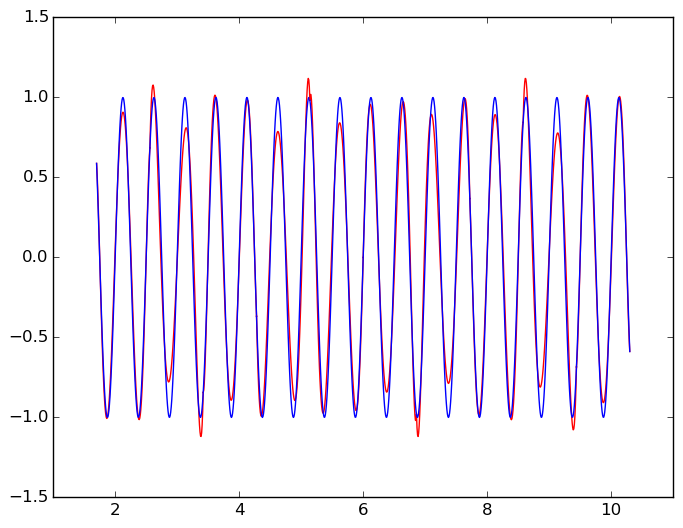

0.2465894470487976

In [194]:
using PyPlot
maxerr = 0.0
for e = 1:nel
    el = elems[e]
    x = (1-ξ)*el.a/2 + (1+ξ)*el.b/2 
    uu = uexact(x)
    err = maxabs(uu-Ue[:,e])
    if err > maxerr maxerr = err end
        
    plot(x, Ue[:,e], "r", x, uu, "b")
end
maxerr